In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from random import normalvariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
from scipy import interpolate, integrate
from scipy.integrate import complex_ode
from scipy import special
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j ,wigner_6j
#from maxwellbloch import mb_solve, field, ob_atom
import matplotlib as mpl
from scipy.integrate import quad
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
def getRaman1(o1, s1, m1, n1, l1):  # 找 M1 sin(kx) cos(ky) cos(kz) taux sigmax 对应的耦合
    if o1 == 'g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, -1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, -1j * 1 / 8),
            (-1, 0, 0, 1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, 1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1 == 'down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal = [] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, -1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, -1j * 1 / 8),
            (0, 1, 1, 1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, 1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            key.append((o2, s2, m1 + dx, n1 + dy, l1 + dz))
            coefffinal.append(coeff * coeffmoment)

    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key, coefffinal

    
def getRaman2(o1,s1,m1,n1,l1): #找 -M1 cos(kx) sin(ky) cos(kz) taux sigmay 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid spin s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, 1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, -1j * 1 / 8),
            (-1, 0, 0, 1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, -1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)

    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, 1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, -1j * 1 / 8),
            (0, 1, 1, 1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, -1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    
    return key,coefffinal

def getRaman3(o1,s1,m1,n1,l1): #找 M2,0 cos(kx) cos(ky) sin(kz) taux sigmaz 对应的耦合
    if o1=='g':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0, -1j * 1 / 8),     
            (0, 0, -1, 1j * 1 / 8),
            (0, -1, 0, -1j * 1 / 8),
            (0, -1, -1, 1j * 1 / 8),
            (-1, 0, 0, -1j * 1 / 8),     
            (-1, 0, -1, 1j * 1 / 8),
            (-1, -1, 0, -1j * 1 / 8),
            (-1, -1, -1, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1 
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1, -1j * 1 / 8),     
            (1, 1, 0, 1j * 1 / 8),
            (1, 0, 1, -1j * 1 / 8),
            (1, 0, 0, 1j * 1 / 8),
            (0, 1, 1, -1j * 1 / 8),     
            (0, 1, 0, 1j * 1 / 8),
            (0, 0, 1, -1j * 1 / 8),
            (0, 0, 0, 1j * 1 / 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def getRaman4(o1,s1,m1,n1,l1): #找 M2,1 cos(kx) cos(ky) cos(kz) taux sigma0 对应的耦合
    if o1=='g':
        o2='e' #o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (0, 0, 0,  1 / 8),     
            (0, 0, -1,  1 / 8),
            (0, -1, 0,  1 / 8),
            (0, -1, -1,  1 / 8),
            (-1, 0, 0,  1 / 8),     
            (-1, 0, -1, 1 / 8),
            (-1, -1, 0,  1/ 8),
            (-1, -1, -1, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    elif o1 == 'e':
        o2='g'#o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        coefffinal=[] 
        for dx, dy, dz, coeffmoment in [
            (1, 1, 1,  1 / 8),     
            (1, 1, 0,  1 / 8),
            (1, 0, 1,  1 / 8),
            (1, 0, 0,  1 / 8),
            (0, 1, 1,  1 / 8),     
            (0, 1, 0, 1 / 8),
            (0, 0, 1,  1/ 8),
            (0, 0, 0, 1/ 8),
        ]:
            mx2 = m1 + dx
            ny2 = n1 + dy
            lz2 = l1 + dz
            key.append((o2, s2, mx2, ny2, lz2))
            coefffinal.append(coeff*coeffmoment)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def getBasis(numm,numn,numl):
    #q = np.array([qx,qy,qz])  
    truncm = list(range(-numm, numm + 1))
    truncn = list(range(-numn, numn + 1))
    truncl = list(range(-numl, numl + 1))
    basis = []
    index_map = {}
    idx = 0
    for o in ['g', 'e']:
        for s in ['up', 'down']:
            for mx in truncm:
                for ny in truncn:
                    for lz in truncl:
                        basis.append((o, s, mx, ny, lz))
                        index_map[(o, s, mx, ny, lz)] = idx
                        idx += 1
    return basis,index_map

def getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        px1 = qx + 2 * m1 + shift[0]
        py1 = qy + 2 * n1 + shift[1]
        pz1 = qz + 2 * l1 + shift[2]
        kinetic = (1/2*px1**2 + 1/2*py1**2 + pz1**2) - 0.5*(V0+V0+Vz) #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic

        # Zeeman 项
        if o1 == 'g':
            H[i, i] += delta 
        elif o1 == 'e':
            H[i, i] -= delta 
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        
        for dx in [-1, 1]:
            key = (o1, s1, m1 + dx, n1, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dy in [-1, 1]:
            key = (o1, s1, m1, n1 + dy, l1)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -V0 / 4

        for dz in [-1, 1]:
            key = (o1, s1, m1, n1, l1 + dz)
            j = index_map.get(key)
            if j is not None:
                H[i, j] += -Vz / 4

        key1,coeff1 = getRaman1(o1,s1,m1,n1,l1)
        key2,coeff2 = getRaman2(o1,s1,m1,n1,l1)
        key3,coeff3 = getRaman3(o1,s1,m1,n1,l1)
        key4,coeff4 = getRaman4(o1,s1,m1,n1,l1)

        for keyi1,keyv1 in enumerate(key1):
            j = index_map.get(keyv1)
            if j is not None:
                H[i, j] += M1*coeff1[keyi1]  # 可根据 σ 的结构继续细化

        for keyi2,keyv2 in enumerate(key2):
            j = index_map.get(keyv2)
            if j is not None:
                H[i, j] += M1*coeff2[keyi2]

        for keyi3,keyv3 in enumerate(key3):
            j = index_map.get(keyv3)
            if j is not None:
                H[i, j] += M20*coeff3[keyi3]

        for keyi4,keyv4 in enumerate(key4):
            j = index_map.get(keyv4)
            if j is not None:
                H[i, j] += M21*coeff4[keyi4]
    return H

# 构造电流算符
def CurrentOperatorZ(qz,numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        #px1 = qx + 2 * m1 + shift[0]
        #py1 = qy + 2 * n1 + shift[1]
        pz1 = qz + 2 * l1 + shift[2]
        kinetic = (2*pz1*1)  #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic
    return H

def CurrentOperatorX(qx,numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        px1 = qx + 2 * m1 + shift[0]
        #py1 = qy + 2 * n1 + shift[1]
        #pz1 = qz + 2 * l1 + shift[2]
        kinetic = (px1*1)  #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic
    return H


def CurrentOperatorY(qy,numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    H = np.zeros((Nb, Nb), dtype=complex)
    #for i, (o1, s1, (m1, n1, l1), (px1, py1, pz1)) in enumerate(basis):
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        # 动能项
        
        if o1 == 'g':
            shift = np.array([0, 0, 0])
        elif o1 == 'e':
            shift = np.array([1, 1, 1])
        else:
            raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
        #px1 = qx + 2 * m1 + shift[0]
        py1 = qy + 2 * n1 + shift[1]
        #pz1 = qz + 2 * l1 + shift[2]
        kinetic = (py1*1)  #(0.5*px1**2 + 0.5*py1**2 + pz1**2) - 0.5*(V0+V0+Vz)
        H[i, i] += kinetic
    return H


def spinoperatorZ(o1,s1,m1,n1,l1):  #tau_0 sigma_z
    if o1=='g':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    elif o1 == 'e':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'up'
            coeff = 1
        elif s1=='down':
            s2 = 'down'
            coeff = -1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def spinoperatorX(o1,s1,m1,n1,l1):  #tau_0 sigma_x
    if o1=='g':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1=='down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    elif o1 == 'e':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'down'
            coeff = 1
        elif s1=='down':
            s2 = 'up'
            coeff = 1
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def spinoperatorY(o1,s1,m1,n1,l1):  #tau_0 sigma_y
    if o1=='g':
        o2 = 'g'
        if s1 == 'up':
            s2 = 'down'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    elif o1 == 'e':
        o2 = 'e'
        if s1 == 'up':
            s2 = 'dwon'
            coeff = -1j
        elif s1=='down':
            s2 = 'up'
            coeff = 1j
        else:
            raise ValueError("Invalid orbital s1: must be 'up' or 'down'")
        key = []
        key.append((o2, s2, m1, n1, l1))
        coefffinal=[] 
        coefffinal.append(coeff)
    else:
        raise ValueError("Invalid orbital o1: must be 'g' or 'e'")
    return key,coefffinal

def spinProjectionOperatorZ(numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    Operator = np.zeros((Nb, Nb), dtype=complex)
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        key, coeff = spinoperatorZ(o1, s1, m1, n1, l1)
        for keyi3,keyv3 in enumerate(key):
            j = index_map.get(keyv3)
            if j is not None:
                Operator[i, j] += coeff[keyi3]
    return Operator

def spinProjectionOperatorX(numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    Operator = np.zeros((Nb, Nb), dtype=complex)
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        key, coeff = spinoperatorX(o1, s1, m1, n1, l1)
        for keyi3,keyv3 in enumerate(key):
            j = index_map.get(keyv3)
            if j is not None:
                Operator[i, j] += coeff[keyi3]
    return Operator


def spinProjectionOperatorY(numm,numn,numl):
    basis,index_map = getBasis(numm,numn,numl)
    Nb = len(basis)
    Operator = np.zeros((Nb, Nb), dtype=complex)
    for i, (o1, s1, m1, n1, l1) in enumerate(basis):
        key, coeff = spinoperatorY(o1, s1, m1, n1, l1)
        for keyi3,keyv3 in enumerate(key):
            j = index_map.get(keyv3)
            if j is not None:
                Operator[i, j] += coeff[keyi3]
    return Operator




def getSpinsectorZ(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    spinsector = spinProjectionOperatorZ(numm,numn,numl)

    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(len(H),1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(len(H),1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup.reshape(len(H),1), Vdown.reshape(len(H),1), Eband[:10], Espin

def getSpinsectorX(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    spinsector = spinProjectionOperatorX(numm,numn,numl)

    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(len(H),1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(len(H),1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup.reshape(len(H),1), Vdown.reshape(len(H),1), Eband[:10], Espin


def getSpinsectorY(qx,qy,qz,numm, numn, numl, V0, Vz, M1, M20, M21, delta):
    H = getHam(qx,qy,qz,numm,numn,numl,V0,Vz,M1,M20,M21,delta)
    spinsector = spinProjectionOperatorY(numm,numn,numl)

    Eband,eigvec = np.linalg.eigh(H)
    U = np.zeros((2,2),dtype=complex)
    for i in range(2):
        for j in range(2):
            U[i,j] = (((eigvec[:,i].reshape(len(H),1)).T.conjugate())@spinsector@(eigvec[:,j].reshape(len(H),1)))[0][0]
    Espin,Vu = np.linalg.eigh(U)
    Vup = Vu[0,1]*eigvec[:,0] + Vu[1,1]*eigvec[:,1]
    Vdown = Vu[0,0]*eigvec[:,0] + Vu[1,0]*eigvec[:,1]
    return Vup.reshape(len(H),1), Vdown.reshape(len(H),1), Eband[:10], Espin





In [15]:
def unitary_from_H_batch(H_batch, dt):
    L, N, _ = H_batch.shape
    U_batch = np.empty_like(H_batch, dtype=complex)
    for k in range(L):
        #w, V = np.linalg.eigh(H_batch[k])
        U_batch[k] = expm(-1j*H_batch[k]*dt)#V @ np.diag(np.exp(-1j*w*dt)) @ V.conj().T
    return U_batch

def pure_to_rho_batch(V_batch):
    """
    V_batch: (L,N,1)
    return:  rho_batch: (L,N,N)
    """
    return V_batch @ np.swapaxes(np.conj(V_batch), 1, 2)

# ---- 主函数：k 分辨的密度矩阵演化，返回 (L, T) ----
def density_evolve_k_resolvedZ(Time, qx, qy, qz_array,
                              numm, numn, numl,
                              V0, Vz, M1, M20,
                              M21_series, delta_series):
    """
    输出：
      Comdt_up: (L, T)
      Comdt_dn: (L, T)
    说明：
      - H(t,k) 由 getHam 构造；若 use_batch_ham=True 且你已有 batch_ham_and_current()，将优先用它提速；
      - J(k) 用你的 CurrentOperatorZ 逐 k 构造（与你现有定义完全一致），时间不变；
      - 初态若不给，则逐 k 调你的 getSpinsector() 取 Vup/Vdown。
    """
    qz_array = np.asarray(qz_array, dtype=float)
    L = len(qz_array)
    T = len(Time)
    dt = Time[1] - Time[0]

    # 1) 初态 Vup/Vdown (L,N,1) —— 用你的 getSpinsector 逐 k 构造（保持与你自旋算符一致）
    
    M21_t0 = M21_series[0]
    delta_t0 = delta_series[0]
        
    _, index_map = getBasis(numm, numn, numl)
    N = len(index_map)
        # 逐 kz
    Vup_list, Vdn_list = [], []
    for kz in qz_array:
        Vup, Vdown, _, _ = getSpinsectorZ(qx, qy, kz, numm, numn, numl,
                                             V0, Vz, M1, M20, M21_t0, delta_t0)
        Vup_list.append(Vup)
        Vdn_list.append(Vdown)
    Vup_batch   = np.stack(Vup_list, axis=0)    # (L,N,1)
    Vdown_batch = np.stack(Vdn_list, axis=0)    # (L,N,1)

    # 2) 纯态 -> 密度矩阵（批）
    rho_up   = pure_to_rho_batch(Vup_batch)     # (L,N,N)
    rho_down = pure_to_rho_batch(Vdown_batch)   # (L,N,N)

    J_batch = np.stack([CurrentOperatorZ(kz, numm, numn, numl) for kz in qz_array], axis=0)  # (L,N,N)

    # 4) 结果容器：(L, T)
    Comdt_up = np.zeros((L, T), dtype=float)
    Comdt_dn = np.zeros((L, T), dtype=float)

    # 5) 时间演化
    for ti in tqdm(range(T)):
        M21_t   = M21_series[ti]
        delta_t = delta_series[ti]

        # 5.1 构造 H_batch(t)（优先用批量版本；没有就回退逐 kz 叠堆）
        
        H_batch = np.stack(
            [getHam(qx, qy, kz, numm, numn, numl, V0, Vz, M1, M20, M21_t, delta_t)
                for kz in qz_array], axis=0)  # (L,N,N)

        # 5.2 U(t) 并推进 ρ： ρ <- U ρ U†   （逐 kz 的批量矩阵乘）
        U_batch = unitary_from_H_batch(H_batch, dt)            # (L,N,N)
        U_dag   = np.swapaxes(np.conj(U_batch), 1, 2)         # (L,N,N)
        rho_up   = U_batch @ rho_up   @ U_dag
        rho_down = U_batch @ rho_down @ U_dag
        
        Comdt_up[:,  ti] = np.real(np.einsum('lij,lji->l', rho_up,   J_batch))
        Comdt_dn[:,  ti] = np.real(np.einsum('lij,lji->l', rho_down, J_batch))

    return Comdt_up, Comdt_dn, rho_up, rho_down


def density_evolve_k_resolvedY(Time, qx, qy_array, qz,
                              numm, numn, numl,
                              V0, Vz, M1, M20,
                              M21_series, delta_series):
                             
    """
    输出：
      Comdt_up: (L, T)
      Comdt_dn: (L, T)
    说明：
      - H(t,k) 由 getHam 构造；若 use_batch_ham=True 且你已有 batch_ham_and_current()，将优先用它提速；
      - J(k) 用你的 CurrentOperatorZ 逐 k 构造（与你现有定义完全一致），时间不变；
      - 初态若不给，则逐 k 调你的 getSpinsector() 取 Vup/Vdown。
    """
    qy_array = np.asarray(qy_array, dtype=float)
    L = len(qy_array)
    T = len(Time)
    dt = Time[1] - Time[0]

    # 1) 初态 Vup/Vdown (L,N,1) —— 用你的 getSpinsector 逐 k 构造（保持与你自旋算符一致）
    
    M21_t0 = M21_series[0]
    delta_t0 = delta_series[0]
        
    _, index_map = getBasis(numm, numn, numl)
    N = len(index_map)
        # 逐 kz
    Vup_list, Vdn_list = [], []
    for ky in qy_array:
        Vup, Vdown, _, _ = getSpinsectorY(qx, ky, qz, numm, numn, numl,
                                             V0, Vz, M1, M20, M21_t0, delta_t0)
        Vup_list.append(Vup)
        Vdn_list.append(Vdown)
    Vup_batch   = np.stack(Vup_list, axis=0)    # (L,N,1)
    Vdown_batch = np.stack(Vdn_list, axis=0)    # (L,N,1)

    # 2) 纯态 -> 密度矩阵（批）
    rho_up   = pure_to_rho_batch(Vup_batch)     # (L,N,N)
    rho_down = pure_to_rho_batch(Vdown_batch)   # (L,N,N)

    J_batch = np.stack([CurrentOperatorY(ky, numm, numn, numl) for ky in qy_array], axis=0)  # (L,N,N)

    # 4) 结果容器：(L, T)
    Comdt_up = np.zeros((L, T), dtype=float)
    Comdt_dn = np.zeros((L, T), dtype=float)

    # 5) 时间演化
    for ti in tqdm(range(T)):
        M21_t   = M21_series[ti]
        delta_t = delta_series[ti]

        # 5.1 构造 H_batch(t)（优先用批量版本；没有就回退逐 kz 叠堆）
        
        H_batch = np.stack(
            [getHam(qx, ky, qz, numm, numn, numl, V0, Vz, M1, M20, M21_t, delta_t)
                for ky in qy_array], axis=0)  # (L,N,N)

        # 5.2 U(t) 并推进 ρ： ρ <- U ρ U†   （逐 kz 的批量矩阵乘）
        U_batch = unitary_from_H_batch(H_batch, dt)            # (L,N,N)
        U_dag   = np.swapaxes(np.conj(U_batch), 1, 2)         # (L,N,N)
        rho_up   = U_batch @ rho_up   @ U_dag
        rho_down = U_batch @ rho_down @ U_dag
        
        Comdt_up[:,  ti] = np.real(np.einsum('lij,lji->l', rho_up,   J_batch))
        Comdt_dn[:,  ti] = np.real(np.einsum('lij,lji->l', rho_down, J_batch))

    return Comdt_up, Comdt_dn, rho_up, rho_down


def density_evolve_k_resolvedX(Time, qx_array, qy, qz,
                              numm, numn, numl,
                              V0, Vz, M1, M20,
                              M21_series, delta_series):
    """
    输出：
      Comdt_up: (L, T)
      Comdt_dn: (L, T)
    说明：
      - H(t,k) 由 getHam 构造；若 use_batch_ham=True 且你已有 batch_ham_and_current()，将优先用它提速；
      - J(k) 用你的 CurrentOperatorZ 逐 k 构造（与你现有定义完全一致），时间不变；
      - 初态若不给，则逐 k 调你的 getSpinsector() 取 Vup/Vdown。
    """
    qx_array = np.asarray(qx_array, dtype=float)
    L = len(qx_array)
    T = len(Time)
    dt = Time[1] - Time[0]

    # 1) 初态 Vup/Vdown (L,N,1) —— 用你的 getSpinsector 逐 k 构造（保持与你自旋算符一致）
    
    M21_t0 = M21_series[0]
    delta_t0 = delta_series[0]
        
    _, index_map = getBasis(numm, numn, numl)
    N = len(index_map)
        # 逐 kz
    Vup_list, Vdn_list = [], []
    for kx in qx_array:
        Vup, Vdown, _, _ = getSpinsectorX(kx, qy, qz, numm, numn, numl,
                                             V0, Vz, M1, M20, M21_t0, delta_t0)
        Vup_list.append(Vup)
        Vdn_list.append(Vdown)
    Vup_batch   = np.stack(Vup_list, axis=0)    # (L,N,1)
    Vdown_batch = np.stack(Vdn_list, axis=0)    # (L,N,1)

    # 2) 纯态 -> 密度矩阵（批）
    rho_up   = pure_to_rho_batch(Vup_batch)     # (L,N,N)
    rho_down = pure_to_rho_batch(Vdown_batch)   # (L,N,N)

    J_batch = np.stack([CurrentOperatorX(kx, numm, numn, numl) for kx in qx_array], axis=0)  # (L,N,N)

    # 4) 结果容器：(L, T)
    Comdt_up = np.zeros((L, T), dtype=float)
    Comdt_dn = np.zeros((L, T), dtype=float)

    # 5) 时间演化
    for ti in tqdm(range(T)):
        M21_t   = M21_series[ti]
        delta_t = delta_series[ti]

        # 5.1 构造 H_batch(t)（优先用批量版本；没有就回退逐 kz 叠堆）
        
        H_batch = np.stack(
            [getHam(kx, qy, qz, numm, numn, numl, V0, Vz, M1, M20, M21_t, delta_t)
                for kx in qx_array], axis=0)  # (L,N,N)

        # 5.2 U(t) 并推进 ρ： ρ <- U ρ U†   （逐 kz 的批量矩阵乘）
        U_batch = unitary_from_H_batch(H_batch, dt)            # (L,N,N)
        U_dag   = np.swapaxes(np.conj(U_batch), 1, 2)         # (L,N,N)
        rho_up   = U_batch @ rho_up   @ U_dag
        rho_down = U_batch @ rho_down @ U_dag
        
        Comdt_up[:,  ti] = np.real(np.einsum('lij,lji->l', rho_up,   J_batch))
        Comdt_dn[:,  ti] = np.real(np.einsum('lij,lji->l', rho_down, J_batch))

    return Comdt_up, Comdt_dn, rho_up, rho_down


In [16]:

V0, Vz = 2.0, 4.0
delta_amp = 0.13
M1, M20, M21 = 1, 1, 0.15
d0 = 0.13
phi0 = 0
#d0 = 0.178 #0.17
qz = np.linspace(-1,1,400)
numm, numn, numl = 2, 2, 3
T = np.arange(100,600,50)
T



array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550])

In [5]:
Comdt_upT = []
Comdt_dnT= []

for Ti in tqdm(T):
    Time = np.arange(0,Ti,0.5)
    theta = 2*np.pi*Time / Time[-1] + phi0
    M21_series   = M21 * np.sin(theta)
    delta_series = d0  - delta_amp * np.cos(theta)

    Comdt_up, Comdt_dn,rhoup,rhodown = density_evolve_k_resolvedZ(
            Time, 0, 0, qz,
            numm, numn, numl,
            V0, Vz, M1, M20,
            M21_series, delta_series)
    Comdt_upT.append(Comdt_up)
    Comdt_dnT.append(Comdt_dn)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [91:53:54<00:00, 33083.50s/it]  


In [23]:
Chargeup = np.zeros(len(T))
Chargedown = np.zeros(len(T))
dt = 0.5
for i in range(len(T)):
    Chargeup[i] = np.sum(Comdt_upT[i])/2/np.pi*(qz[1]-qz[0])*dt
    Chargedown[i] = np.sum(Comdt_dnT[i])/2/np.pi*(qz[1]-qz[0])*dt


In [21]:
Comdt_upT_obj = np.empty(len(Comdt_upT), dtype=object)
Comdt_upT_obj[:] = list(Comdt_upT)

Comdt_dnT_obj = np.empty(len(Comdt_dnT), dtype=object)
Comdt_dnT_obj[:] = list(Comdt_dnT)

In [ ]:
np.savez_compressed(
    "Fig3(b).npz",
    Comdt_upT=Comdt_upT_obj,
    Comdt_dnT=Comdt_dnT_obj,
    Chargeup=np.asarray(Chargeup),
    Chargedown=np.asarray(Chargedown),
    T=np.asarray(T),
)

In [20]:
data = np.load("Fig3(b).npz", allow_pickle=True)
Comdt_upT1  = data["Comdt_upTnpz"].tolist()
Comdt_dnT1  = data["Comdt_dnTnpz"].tolist()
Chargeup1   = data["Chargeupnpz"]
Chargedown1 = data["Chargedownnpz"]
T          = data["T"]

([<matplotlib.axis.YTick at 0x71864e49a850>,
 [Text(0, 1.0, '1.0'), Text(0, 1.1, '1.1')])

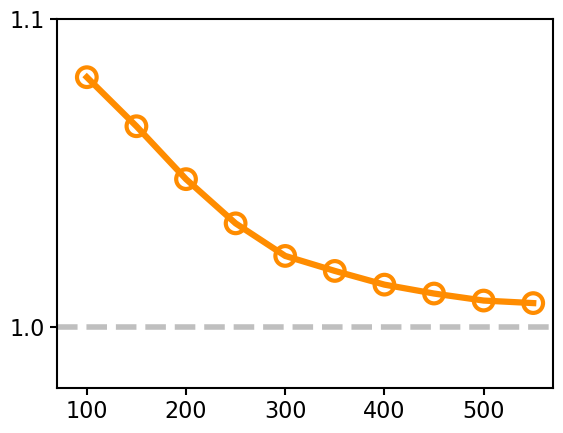

In [21]:
y = (Chargeup1 - Chargedown1) / 2

# 虚线（最底层）
plt.rcParams.update({
    "axes.linewidth": 1.5,        # 坐标轴边框线宽（spines）
    "xtick.major.width": 1.5,     # x 主刻度线宽
    "ytick.major.width": 1.5,     # y 主刻度线宽
    "xtick.minor.width": 1.0,     # x 次刻度线宽（若用到）
    "ytick.minor.width": 1.0,     # y 次刻度线宽（若用到）
    "xtick.major.size": 5,        # x 主刻度长度
    "ytick.major.size": 5,        # y 主刻度长度
    "xtick.minor.size": 5,
    "ytick.minor.size": 5,
    "font.size": 16,              # 全局字体大小（含 tick）
    "axes.labelsize": 18,         # 坐标轴 label 字号
    "axes.labelweight": "bold",   # label 加粗
})
#plt.axhline(-1, ls='--', linewidth=4, c='gray', zorder=1)
plt.axhline( 1, ls='--', linewidth=4, c='gray', zorder=1,alpha=0.5)

# 实线连接（中间层）：淡一点 + 粗
plt.plot(
    T, y,
    '-', color='darkorange', alpha=1, linewidth=4.5,
    zorder=2
)

# 点（最上层）：空心圆 + 大
plt.scatter(
    T, y,
    marker='o',
    s=200,                    # 点大小（面积），可继续加大
    facecolors='none',        # 空心
    edgecolors='darkorange',
    linewidths=3,
    zorder=3
)

plt.ylim(0.98, 1.1)
plt.xlim(70,570)
plt.yticks([1,1.1])
#plt.savefig('ChargePump.svg')